In [1]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
def removed_outliers(df, column, level=3):
    return df[((df[column] - df[column].mean()) / df[column].std()).abs() < level]

In [3]:
ac_df = pd.read_csv('unical_mount_point/active_cells_gpu_32_4000_10000_36_coverage.csv',
                   skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time'])
ac_df.head()

,iteration_no,ac_coverage,ac_iter_time
0,10,0.040725,1315
1,20,0.171225,1102
2,30,0.383625,1176
3,40,0.630225,7409
4,50,0.839700,9164


In [4]:
u_df = pd.read_csv('unical_mount_point/unified_memory_32_4000_10000_36_coverage.csv',
                  skiprows=1, names=['iteration_no', 'u_coverage', 'u_iter_time'])
u_df.drop('u_coverage', axis=1, inplace=True)
u_df.head()

,iteration_no,u_iter_time
0,10,2660
1,20,2664
2,30,2656
3,40,2656
4,50,2657


In [5]:
comp_df = pd.merge(ac_df, u_df, how='inner', on='iteration_no')
comp_df.describe()

,iteration_no,ac_coverage,ac_iter_time,u_iter_time
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,5005.000000,70.896090,676.87500,130.821000
std,2888.194361,32.329847,44947.78501,44692.664234
min,10.000000,0.040725,-997230.00000,-997835.000000
25%,2507.500000,44.260987,1983.00000,1966.750000
50%,5005.000000,84.890250,2151.00000,2115.500000
75%,7502.500000,99.995789,2789.25000,2256.000000
max,10000.000000,100.000000,107766.00000,2664.000000


Text(0.5, 1.0, 'Raw data visualisation for an example run')

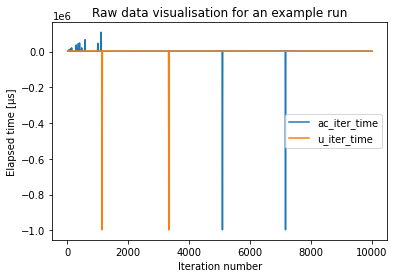

In [37]:
ax = plt.gca()
comp_df.plot(x='iteration_no', y='ac_iter_time', ax=ax)
comp_df.plot(x='iteration_no', y='u_iter_time', ax=ax)

plt.xlabel('Iteration number')
plt.ylabel('Elapsed time [μs]')
plt.title('Raw data visualisation for an example run')

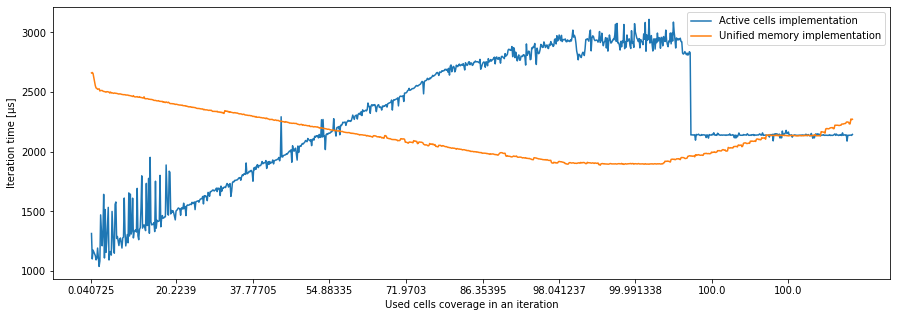

In [7]:
cleaned_df = removed_outliers(comp_df, 'ac_iter_time', level=0.13)
cleaned_df = removed_outliers(cleaned_df, 'u_iter_time', level=0.13)

_, ax = plt.subplots(figsize=(15, 5))

ax.plot(cleaned_df.iteration_no, cleaned_df.ac_iter_time, label='Active cells implementation')
ax.plot(cleaned_df.iteration_no, cleaned_df.u_iter_time, label='Unified memory implementation')

iteration_no = cleaned_df['iteration_no'].values
xticks = [iter_no for i, iter_no in enumerate(iteration_no) if i % 100 == 0]
labels_ids = [i for i, _ in enumerate(iteration_no) if i % 100 == 0]
ax.set_xticks(xticks)
ax.set_xticklabels([cleaned_df.ac_coverage.iloc[i] for i in labels_ids])

plt.xlabel('Used cells coverage in an iteration')
plt.ylabel('Iteration time [μs]')
plt.title('Raw data visualisation for an example run')
plt.legend()
plt.show()

### Averaged results

In [8]:
ac_to_avg = glob('unical_mount_point/ac_*')

inter_df = pd.DataFrame()
for i, path in enumerate(ac_to_avg):
    df = pd.read_csv(path, skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time'])
    inter_df[i] = df.ac_iter_time

avg_20_comp = pd.read_csv(ac_to_avg[0], skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time'])
avg_20_comp['ac_iter_time'] = inter_df.median(axis=1)
avg_20_comp.head()

,iteration_no,ac_coverage,ac_iter_time
0,10,0.040725,1373.0
1,20,0.171225,1335.0
2,30,0.383625,1337.5
3,40,0.630225,7507.5
4,50,0.839700,9361.5


In [9]:
u_to_avg = glob('unical_mount_point/u_*')

inter_df = pd.DataFrame()
for i, path in enumerate(u_to_avg):
    df = pd.read_csv(path, skiprows=1, names=['iteration_no', 'u_coverage', 'u_iter_time'])
    inter_df[i] = df.u_iter_time

avg_20_comp['u_iter_time'] = inter_df.median(axis=1)
avg_20_comp.head()

,iteration_no,ac_coverage,ac_iter_time,u_iter_time
0,10,0.040725,1373.0,3263.0
1,20,0.171225,1335.0,3003.5
2,30,0.383625,1337.5,3000.0
3,40,0.630225,7507.5,2996.0
4,50,0.839700,9361.5,2994.0


Text(0, 0.5, 'Elapsed time [μs]')

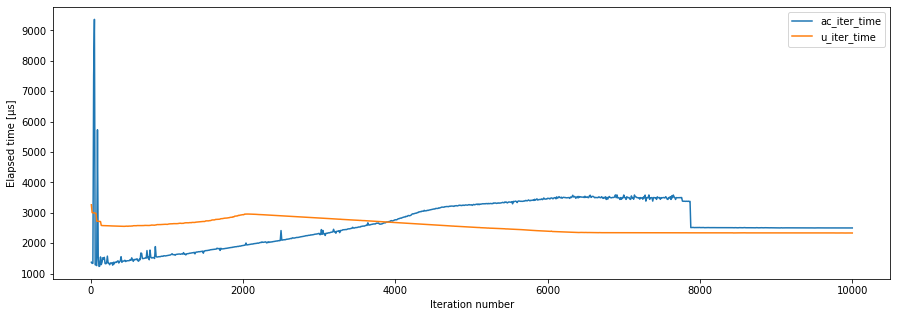

In [35]:
_, ax = plt.subplots(figsize=(15, 5))
avg_20_comp.plot(x='iteration_no', y='ac_iter_time', ax=ax)
avg_20_comp.plot(x='iteration_no', y='u_iter_time', ax=ax)

plt.xlabel('Iteration number')
plt.ylabel('Elapsed time [μs]')

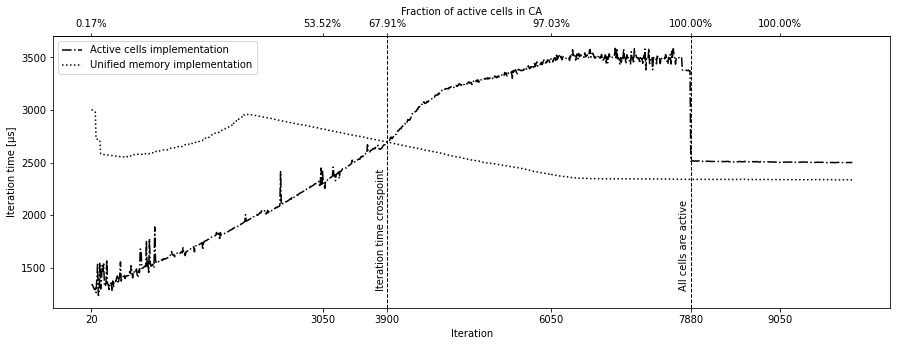

In [34]:
cleaned_df = removed_outliers(avg_20_comp, 'ac_iter_time', level=3)
cleaned_df = removed_outliers(cleaned_df, 'u_iter_time', level=3)
cleaned_df.reset_index(drop=True, inplace=True)

_, ax = plt.subplots(figsize=(15, 5))

ax.plot(cleaned_df.iteration_no, cleaned_df.ac_iter_time, label='Active cells implementation', c='black', ls='-.')
ax.plot(cleaned_df.iteration_no, cleaned_df.u_iter_time, label='Unified memory implementation', c='black', ls=':')

iteration_no = cleaned_df['iteration_no']

first_100 = (cleaned_df['ac_coverage'] == 100).idxmax()
ax.axvline(x=iteration_no[first_100], lw=1, ls='--', c='black')
ax.text(iteration_no[first_100] - 150, 1300, 'All cells are active', rotation=90)

cross_point = (cleaned_df['ac_iter_time'] == cleaned_df['u_iter_time']).idxmax()
ax.axvline(x=iteration_no[cross_point], lw=1, ls='--', c='black')
ax.text(iteration_no[cross_point] - 150, 1300, 'Iteration time crosspoint', rotation=90)

x = cleaned_df.shape[0] / 10

xs = [i for i in range(cleaned_df.shape[0]) if i % 300 == 0] + [cross_point, first_100]
xticks = [iteration_no[i] for i in xs]

ax.set_xlabel('Iteration')
ax.set_ylabel('Iteration time [μs]')
ax.set_xticks(xticks)

secax = ax.secondary_xaxis('top')
secax.set_xlabel('Fraction of active cells in CA')

secax.set_xticks(xticks)
secax.set_xticklabels([
    f'{cleaned_df[cleaned_df.iteration_no == i].ac_coverage.iloc[0]:.2f}%'
    for i in xticks
])

plt.legend()
plt.show()

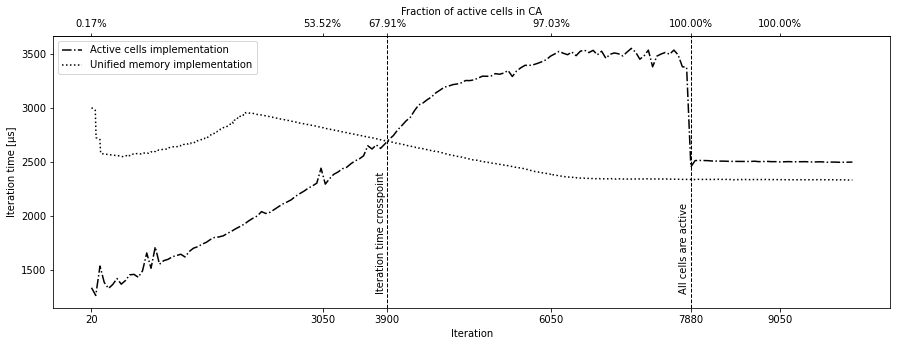

In [30]:
from scipy.interpolate import make_interp_spline, BSpline

cleaned_df = removed_outliers(avg_20_comp, 'ac_iter_time', level=3)
cleaned_df = removed_outliers(cleaned_df, 'u_iter_time', level=3)
cleaned_df.reset_index(drop=True, inplace=True)

_, ax = plt.subplots(figsize=(15, 5))

T = cleaned_df.iteration_no
new_iter_no = np.linspace(T.min(), T.max(), 180) 
spl = make_interp_spline(T, cleaned_df.ac_iter_time, k=3)
ac_iter_time_smooth = spl(new_iter_no)

ax.plot(new_iter_no, ac_iter_time_smooth, label='Active cells implementation', c='black', ls='-.')
ax.plot(cleaned_df.iteration_no, cleaned_df.u_iter_time, label='Unified memory implementation', c='black', ls=':')

iteration_no = cleaned_df['iteration_no']

first_100 = (cleaned_df['ac_coverage'] == 100).idxmax()
ax.axvline(x=iteration_no[first_100], lw=1, ls='--', c='black')
ax.text(iteration_no[first_100] - 150, 1300, 'All cells are active', rotation=90)

cross_point = (cleaned_df['ac_iter_time'] == cleaned_df['u_iter_time']).idxmax()
ax.axvline(x=iteration_no[cross_point], lw=1, ls='--', c='black')
ax.text(iteration_no[cross_point] - 150, 1300, 'Iteration time crosspoint', rotation=90)

x = cleaned_df.shape[0] / 10

xs = [i for i in range(cleaned_df.shape[0]) if i % 300 == 0] + [cross_point, first_100]
xticks = [iteration_no[i] for i in xs]

ax.set_xlabel('Iteration')
ax.set_ylabel('Iteration time [μs]')
ax.set_xticks(xticks)

secax = ax.secondary_xaxis('top')
secax.set_xlabel('Fraction of active cells in CA')

secax.set_xticks(xticks)
secax.set_xticklabels([
    f'{cleaned_df[cleaned_df.iteration_no == i].ac_coverage.iloc[0]:.2f}%'
    for i in xticks
])

plt.legend()
plt.show()